In [191]:
# importovanje potrebnih biblioteka
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.stats import kstest
from scipy.stats import chisquare
from scipy.stats import chi2

In [256]:
# ucitavanje skupa podataka
data = pd.read_csv("nikola_jokic.csv")

# u pitanju su statistički podaci košarkaša Nikole Jokića od sezone 2015-2016 do 2018-2019
# izvor https://www.lineups.com/nba/player-stats/nikola-jokic

# napomena: objasniću skraćenice za podatke koje budem koristio, za ostale pogledati https://stats.nba.com/help/glossary/

# prikaz poslednjih 5 redova
data.tail()

,Date,Opp,Score,MIN,PTS,TRB,AST,STL,BLK,TOV,...,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,ORB,DRB
288,1/10/16,CHA,W 95-92,23,4,7,9,0,1,1,...,4,50%,0,1,0%,0,0,0%,0,7
289,1/8/16,MEM,L 84-91,18,9,5,1,0,0,1,...,4,100%,1,1,100%,0,0,0%,3,2
290,1/6/16,MIN,W 78-74,25,4,5,3,0,0,2,...,5,40%,0,1,0%,0,0,0%,2,3
291,1/3/16,POR,L 106-112,21,9,10,2,2,1,2,...,7,42.9%,0,1,0%,3,4,75%,4,6
292,1/2/16,GS,L 108-111,5,0,1,1,0,0,2,...,0,0%,0,0,0%,0,0,0%,0,1


## 1) Estimacija uslovnih i bezuslovnih verovatnoća određenih događaja

Koristimo sledeće atribute (kolone):
    - PTS - broj poena
    - FG% - ukupan procenat šuta i igre (računajući i za dva i za tri poena=

In [51]:
atributi = ["PTS", "FG%", "3P%", "FT%"]
data_por = data[atributi]
data_por["FG%"] = data_por["FG%"].str.rstrip('%').astype('float')
data_por["3P%"] = data_por["3P%"].str.rstrip('%').astype('float')
data_por["FT%"] = data_por["FT%"].str.rstrip('%').astype('float')
data_por.head()

C:\Users\Sovta\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Sovta\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Sovta\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,PTS,FG%,3P%,FT%
0,29,42.3,33.3,71.4
1,29,66.7,66.7,87.5
2,25,55.6,0.0,83.3
3,21,53.3,100.0,100.0
4,33,52.0,57.1,60.0


Pogledaćemo prvo bezuslovnu verovatnoću za broj poena.
Ona se dobija sledećom formulom:
    
$$P(\text{T broj poena}) = \frac{\text{Određeni interval poena}}
{\text{Ukupan broj utakmica}}$$

Ovo je empirijska ocena - što je veći uzorak veća je preciznost.

In [52]:
# broj utakmica na kojima je postigao ispod 15 poena 
data_temp1 = (data_por["PTS"] < 15).value_counts()[True]

# broj utakmica na kojima je postigao između 15 i 30 poena 
data_temp2 = ((data_por["PTS"] >= 15) & (data_por["PTS"] < 30)).value_counts()[True]

# broj utakmica na kojima je postigao iznad 30 poena 
data_temp3 = (data_por["PTS"] >= 30).value_counts()[True]

# ukupan broj utakmica
ukupan_broj_utakmica = len(data_por)

print(data_temp1, data_temp2, data_temp3, ukupan_broj_utakmica)

113 157 23 293


Broj poena      Verovatnoca
< 15 poena         0.385666
15 do 30 poena     0.535836
preko 30 poena     0.078498


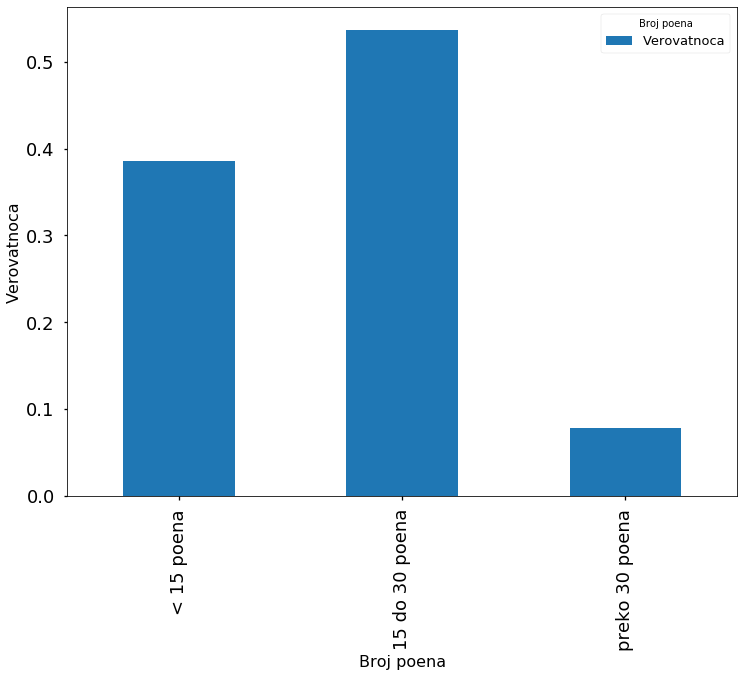

In [53]:
# Računanje bezuslovne verovatnoće, delimo broj utakmica na kojima je postignuto N poena sa ukupnim brojem utakmica
P_broj_poena = pd.DataFrame([data_temp1, data_temp2, data_temp3] / (data_temp1 + data_temp2 + data_temp3))
P_broj_poena.index = ["< 15 poena", "15 do 30 poena", "preko 30 poena"]
P_broj_poena.columns = ["Verovatnoca"]
P_broj_poena.columns.name = "Broj poena"
print(P_broj_poena)

# Plotovanje bar grafika
P_broj_poena.plot.bar(figsize = (12, 9), fontsize = 18)
plt.ylabel("Verovatnoca", fontsize = 16)
plt.xlabel("Broj poena", fontsize = 16)
plt.show()

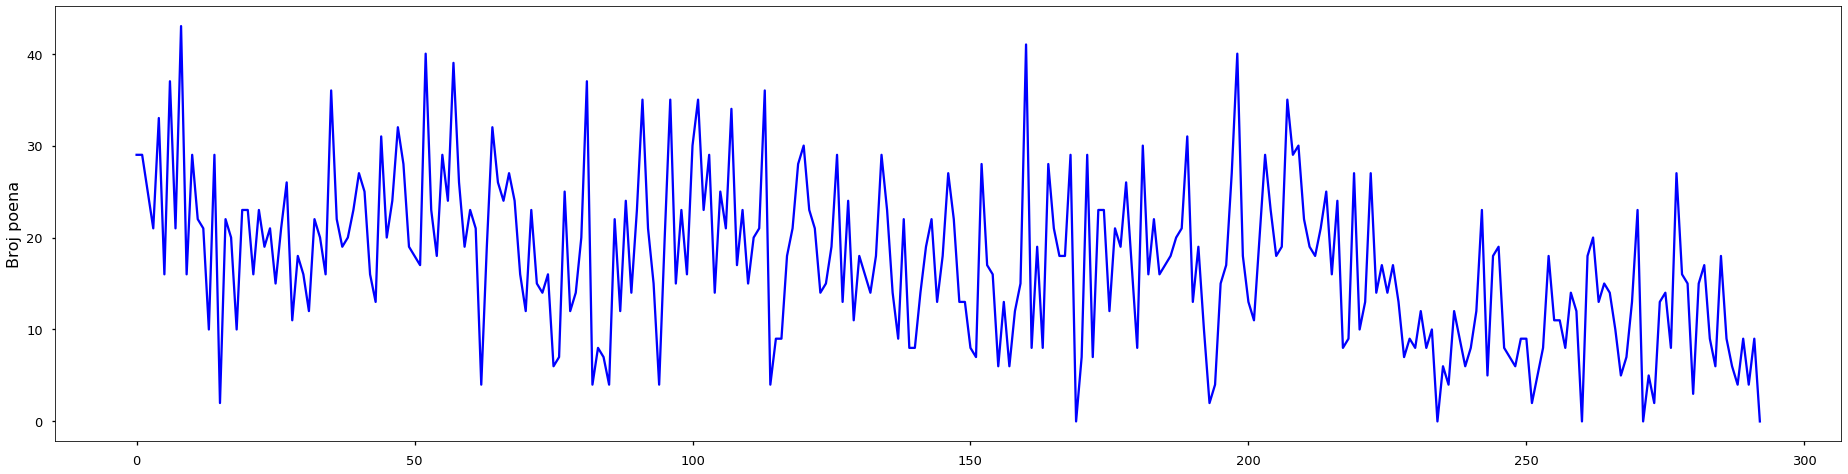

In [54]:
# Prikazaćemo kretanje broja postignutih poena (formu igrača) tokom posmatranog perioda
broj_poena = pd.Series(data = data_por["PTS"].values)
plt.figure(figsize = (32, 8))
plt.ylabel("Broj poena", fontsize = 16)
plt.plot(broj_poena, c = "b")

Sada ćemo posmatrati atribute vezane za procente šuta:
    - FG% - procenat šuta iz igre
    - 3P% - procenat šuta za tri
    - FT% - procenat šuta sa slobodnih bacanja
    
Izračunaćemo verovatnoću da je na utakmici imao preko 60% procenta šut iz igre, preko 40% za
tri poena i preko 80% sa slobodnih bacanja.

In [55]:
data_temp = ((data_por["FG%"] >= 60) & (data_por["3P%"] >= 40) & (data_por["FT%"] >= 80)).value_counts()
data_temp

False    260
True      33
dtype: int64

Procenti suta        Verovatnoca
ispod 80%, 60%, 40%     0.887372
preko 80%, 60%, 40%     0.112628


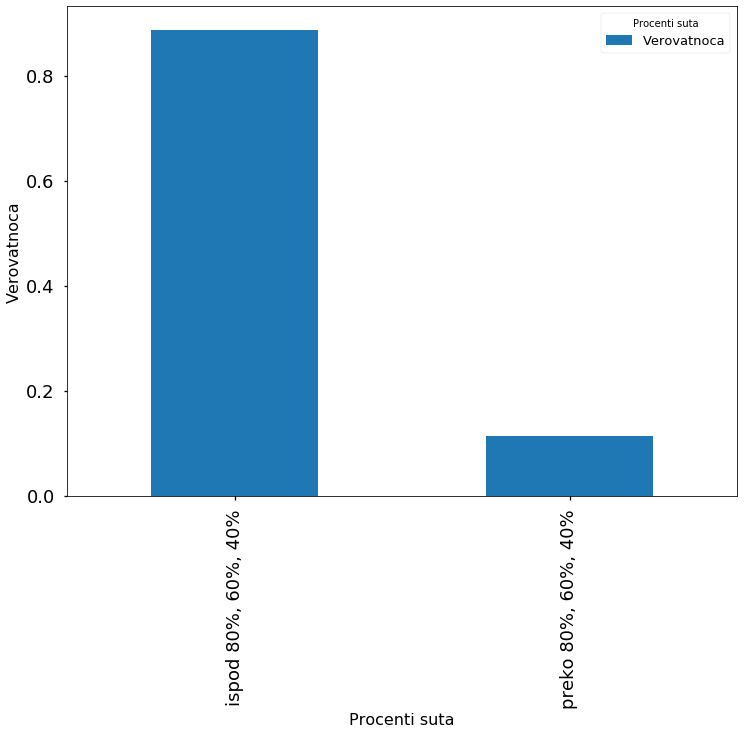

In [56]:
P_preko = pd.DataFrame(data_temp / data_temp.sum())
P_preko.index = ["ispod 80%, 60%, 40%", "preko 80%, 60%, 40%"]
P_preko.columns = ["Verovatnoca"]
P_preko.columns.name = "Procenti suta"
print(P_preko)

P_preko.plot.bar(figsize = (12, 9), fontsize = 18)
plt.ylabel("Verovatnoca", fontsize = 16)
plt.xlabel("Procenti suta", fontsize = 16)
plt.show()

Sada hoćemo da pronađemo verovatnoću procenta šuta iz igre (FG%) pod uslovom da je Nikola postigao minimum 20 poena.

$$P(\text{procenat šuta T}\ |\ \text{broj poena preko 20})=\frac{\frac{\text{Broj utakmica sa procentom šuta T i preko 20 poena}}{\text{Ukupan broj utakmica}}}{\frac{\text{Ukupan broj utakmica preko 20 poena}}{\text{Ukupan broj utakmica}}}$$

$$P(\text{procenat šuta T}\ |\ \text{broj poena preko 20})= \frac{\text{Broj utakmica sa procentom šuta T i preko 20 poena}}{\text{Ukupan broj utakmica preko 20 poena}}$$

In [57]:
broj_poena = 20
procenat_suta = 60.0
# Series objekat sa utakmicama u kojima postignut broj poena preko 20 i njihovim procentima
data_temp = data_por.loc[data_por["PTS"] >= broj_poena, "FG%"]
print(data_temp)

0      42.3
1      66.7
2      55.6
3      53.3
4      52.0
6      61.1
7      34.6
8      63.3
10     45.5
11     57.1
12     46.7
14     50.0
16     60.0
17     90.0
19     73.3
20     62.5
22     41.7
24     40.0
26     64.3
27     52.4
32     71.4
33     63.6
35     44.0
36     56.2
38     41.2
39     43.8
40     50.0
41     61.5
44     80.0
45     56.2
       ... 
165    56.2
168    64.3
171    64.3
173    50.0
174    69.2
176    55.6
178    68.8
181    66.7
183    50.0
187    58.3
188    80.0
189    86.7
197    50.0
198    73.9
202    53.3
203    57.1
204    56.2
207    63.6
208    54.5
209    68.4
210    63.6
213    47.1
214    69.2
216    68.8
219    76.5
222    83.3
242    50.0
262    45.0
270    66.7
277    66.7
Name: FG%, Length: 115, dtype: float64


Verovatnoca za odredjeni procenat suta


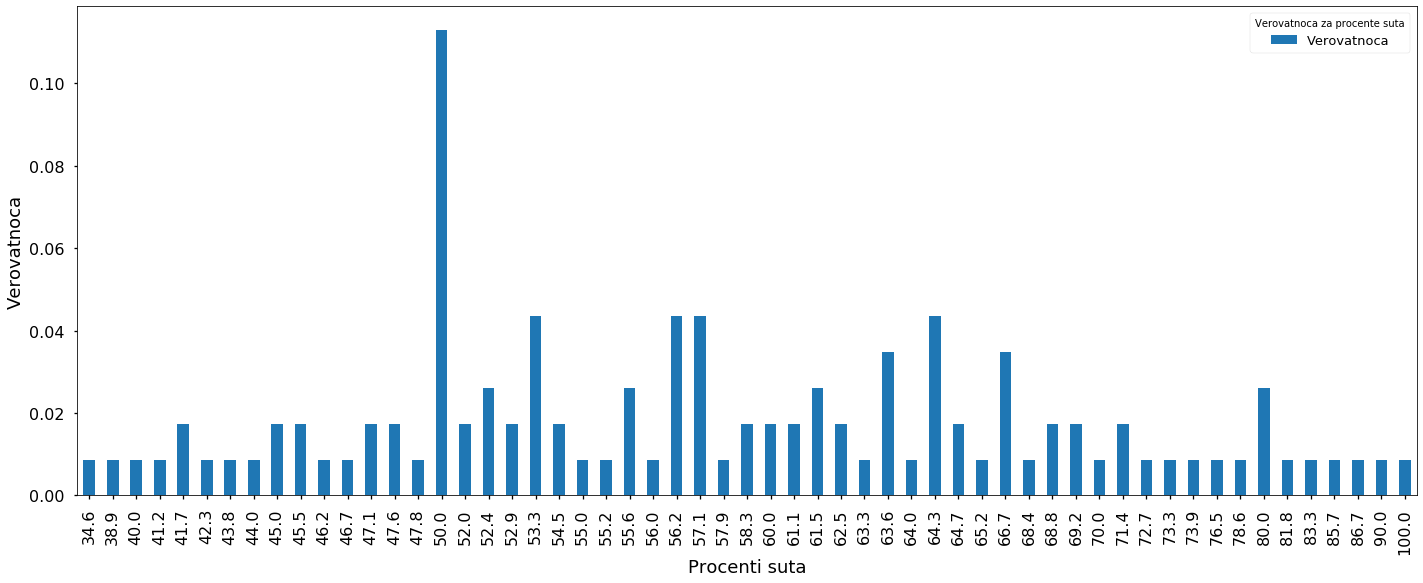

In [58]:
# prikazujemo verovatnocu za sve procente
P_procenat = pd.DataFrame((data_temp.value_counts()) / data_temp.shape[0]).sort_index()
P_procenat.columns = ["Verovatnoca"]
P_procenat.columns.name = "Verovatnoca za procente suta"
print("Verovatnoca za odredjeni procenat suta")

P_procenat.plot.bar(figsize = (24, 9), fontsize = 16)
plt.xlabel("Procenti suta", fontsize = 18)
plt.ylabel("Verovatnoca", fontsize = 18)
plt.show()

In [59]:
# izvlacimo utakmice sa procentom preko 60%
data_temp1 = (data_temp >= procenat_suta).value_counts()
data_temp1

False    66
True     49
Name: FG%, dtype: int64

Verovatnoca da je procenat suta bio preko 60% pod uslovom da je broj poena iznad 20


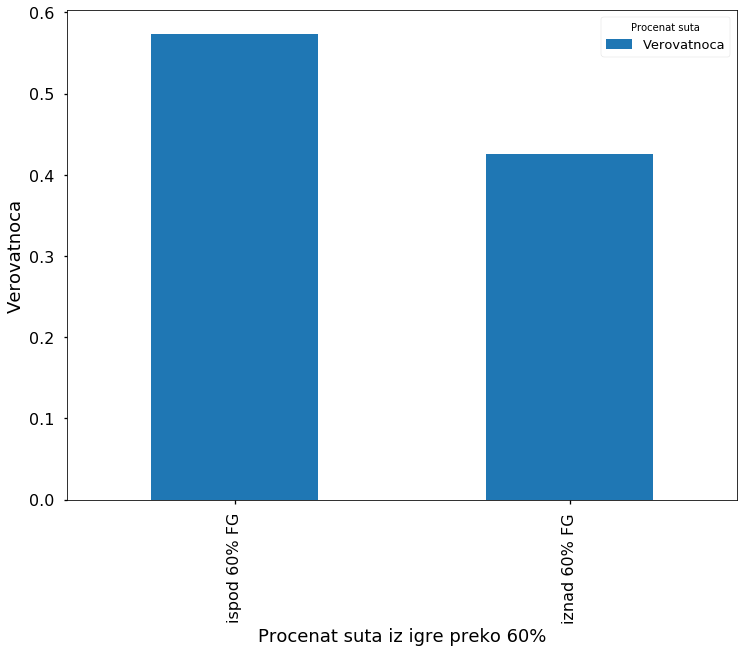

In [60]:
# racunamo verovatnocu da je postigao 20 ili vise poena pod uslovom da je procenat suta veci od 60.0
P_visok_procenat = pd.DataFrame(data_temp1 / len(data_temp))
P_visok_procenat.index = ["ispod 60% FG", "iznad 60% FG"]
P_visok_procenat.columns = ["Verovatnoca"]
print("Verovatnoca da je procenat suta bio preko 60% pod uslovom da je broj poena iznad 20")

P_visok_procenat.columns.name = "Procenat suta"
P_visok_procenat.plot.bar(figsize = (12, 9), fontsize = 16)
plt.xlabel("Procenat suta iz igre preko 60%", fontsize = 18)
plt.ylabel("Verovatnoca", fontsize = 18)
plt.show()

Možemo da rezonujemo i na obrnut način: Hoćemo da predvidimo verovatnoću da će Nikola postići preko 20 poena pod uslovom da ima odredjen procenat suta. Za računanje ovoga mozemo koristiti Bajesovo pravilo: 

$$P(\text{preko 20 poena}\ |\  \text{procenat suta})=\frac{P(\text{pocenat suta}\ |\ \text{preko 20 poena})P(\text{preko 20 poena})}{P(\text{procenat suta})}$$

In [61]:
# broj utakmica na kojima je postigao iznad 20 poena 
broj_poena_preko = (data_por["PTS"] >= 20).value_counts()[True]
# Verovatnoca za broj poena preko 20
P_broj_poena_preko = broj_poena_preko / ukupan_broj_utakmica
P_broj_poena_preko

0.3924914675767918

In [62]:
# Bezuslovna verovatnoca za procente suta
# broj utakmica na kojima je procenat bio ispod 60%  
data_temp1 = (data_por["FG%"] < 60).value_counts()[True]

# broj utakmica na kojima je procenat bio iznad 60% 
data_temp2 = (data_por["FG%"] >= 60).value_counts()[True]

data_temp1, data_temp2

(200, 93)

Verovatnoca da je procenat suta bio preko 60%


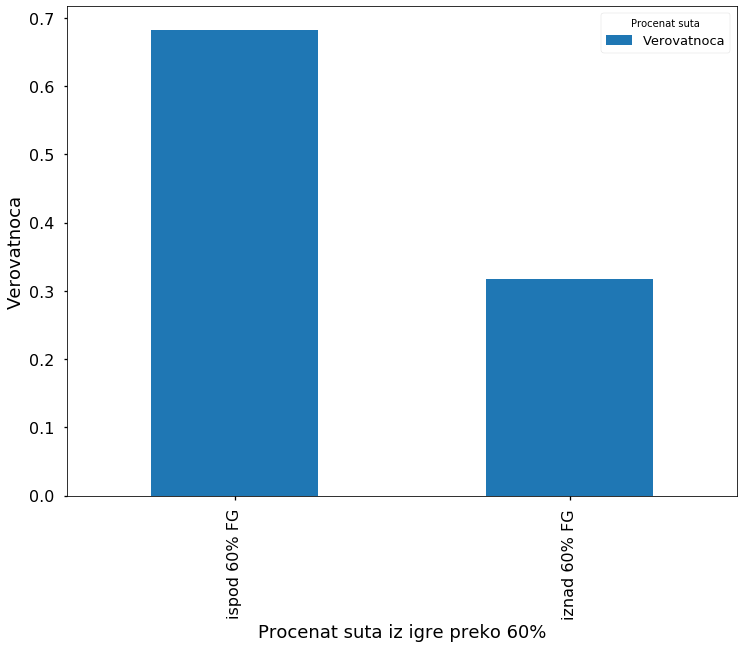

In [63]:
P_procenti = pd.DataFrame([data_temp1, data_temp2] / (data_temp1 + data_temp2))
P_procenti.index = ["ispod 60% FG", "iznad 60% FG"]
P_procenti.columns = ["Verovatnoca"]
print("Verovatnoca da je procenat suta bio preko 60%")

P_procenti.columns.name = "Procenat suta"
P_procenti.plot.bar(figsize = (12, 9), fontsize = 16)
plt.xlabel("Procenat suta iz igre preko 60%", fontsize = 18)
plt.ylabel("Verovatnoca", fontsize = 18)
plt.show()

Verovatnoca visokog broja poena (preko 20) pod uslovom da su dati procenti suta


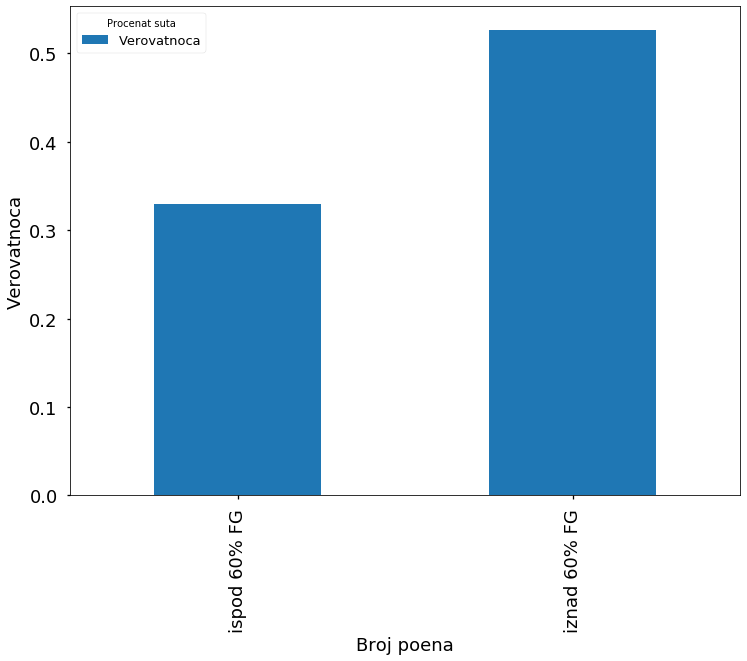

In [64]:
P_bajes = P_visok_procenat * P_broj_poena_preko / P_procenti
print("Verovatnoca visokog broja poena (preko 20) pod uslovom da su dati procenti suta")

pd.DataFrame(P_bajes).plot.bar(figsize = (12, 9), fontsize = 18)
plt.xlabel("Broj poena", fontsize = 18)
plt.ylabel("Verovatnoca", fontsize = 18)
plt.show()

## 2) Estimacija parametara raspodela pojedinačnih promenljivih (matematičko očekivanje, varijansa, standardna devijacija, medijana, kvartili, kvantili...)

Hoćemo da pronađemo raspodelu poena za poslednje dve sezone.
Koristićemo sledeću statističku aproksimaciju: $$P(p|s)=\frac{\text{Broj poena u sezoni s}}{\text{Ukupan broj utakmica u sezoni s}}$$

In [65]:
plt.style.use("seaborn-talk")
atributi = ["Date", "PTS"]
data_por = pd.read_csv("nikola_jokic.csv", usecols = atributi)
data_por["Date"] = pd.to_datetime(data_por["Date"])
data_por.head()

,Date,PTS
0,2019-05-12,29
1,2019-05-09,29
2,2019-05-07,25
3,2019-05-05,21
4,2019-05-03,33


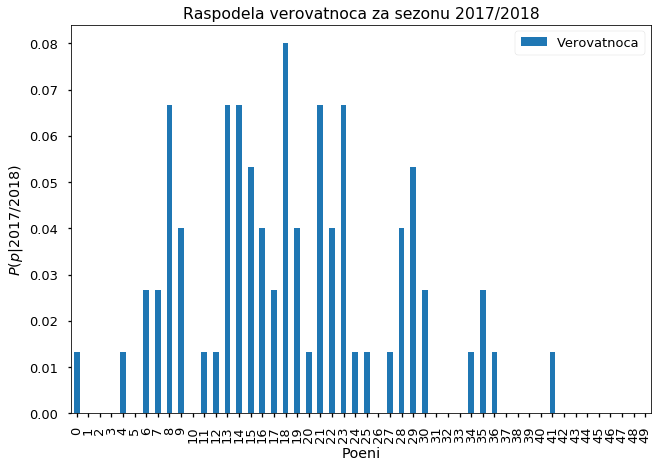

In [66]:
# Za sezonu 2017/2018
P_PTS_za_2018 = pd.DataFrame(index = range(50))
mask = (data_por['Date'] >= '2017-10-01') & (data_por['Date'] < "2018-10-01")
data_temp = data_por.loc[mask, "PTS"].value_counts()
P_PTS_za_2018["Verovatnoca"] = (data_temp / data_temp.sum())

P_PTS_za_2018.plot.bar()
plt.xlabel("Poeni")
plt.ylabel("$P(p|2017/2018)$")
plt.title("Raspodela verovatnoca za sezonu 2017/2018")
plt.show()

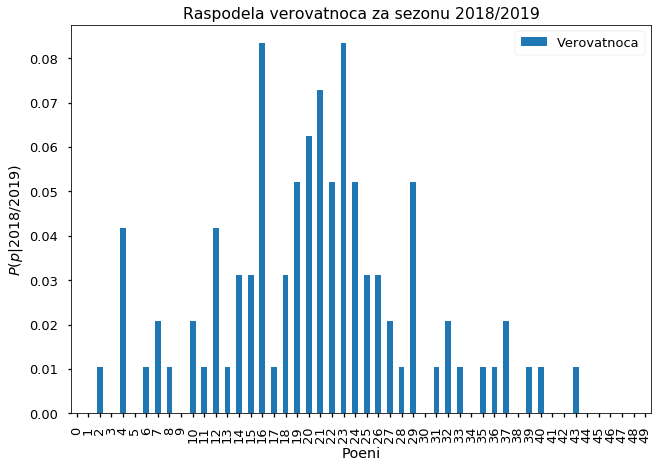

In [67]:
# Za sezonu 2018/2019
P_PTS_za_2019 = pd.DataFrame(index = range(50))
mask = (data_por['Date'] >= '2018-10-01') & (data_por['Date'] < "2019-10-01")
data_temp = data_por.loc[mask, "PTS"].value_counts()
P_PTS_za_2019["Verovatnoca"] = (data_temp / data_temp.sum())

P_PTS_za_2019.plot.bar()
plt.xlabel("Poeni")
plt.ylabel("$P(p|2018/2019)$")
plt.title("Raspodela verovatnoca za sezonu 2018/2019")
plt.show()

Sada koristimo formulu totalne verovatnoće da izračunamo 
    s1 = sezona 2017/2018
    s2 = sezona 2018/2019

$$P(p) = P(p,s1)+P(p,s2) = P(s1)P(p|s1)+P(s2)P(p|s2)$$.

Dakle, prvo treba da izračunamo $P(s)$ da slučajno izabrana utakmica pripada sezoni $s$.

<b>Estimiranje $\mathbf{P(s)}$</b> 

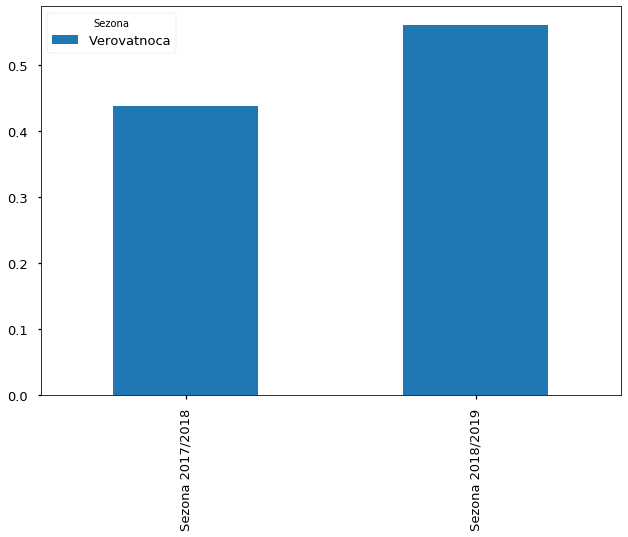

In [68]:
mask = (data_por['Date'] >= '2017-10-01') & (data_por['Date'] < "2018-10-01")
data_temp1 = data_por.loc[mask, "PTS"].value_counts()

mask = (data_por['Date'] >= '2018-10-01') & (data_por['Date'] < "2019-10-01")
data_temp2 = data_por.loc[mask, "PTS"].value_counts()

P_S = pd.DataFrame([data_temp1.sum(), data_temp2.sum()] / (data_temp1.sum() + data_temp2.sum()))
P_S.index = ["Sezona 2017/2018", "Sezona 2018/2019"]
P_S.columns = ["Verovatnoca"]
P_S.columns.name = "Sezona"
P_S.plot.bar()
plt.show()

<b>Izračunavanje $\mathbf{P(p)}$</b>

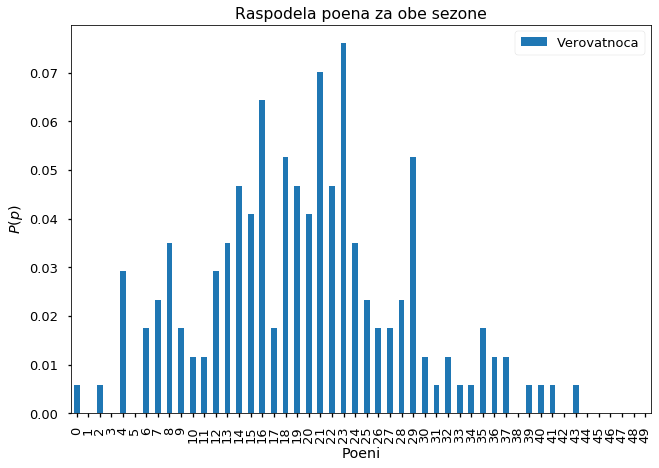

In [69]:
P_PTS_za_2018 = P_PTS_za_2018.fillna(0)
P_PTS_za_2019 = P_PTS_za_2019.fillna(0)

P_PTS = P_PTS_za_2018 * P_S.loc["Sezona 2017/2018"] + P_PTS_za_2019 * P_S.loc["Sezona 2018/2019"]

P_PTS.plot.bar()
plt.xlabel("Poeni")
plt.ylabel("$P(p)$")
plt.title("Raspodela poena za obe sezone")
plt.show()

### Matematičko očekivanje 
Očekivane poene možemo pronaći pomoću sledećih jednačina:
$$E[P\ |\ S=s] = \sum_{g=0}^{50}pP(p|s) \ \ s\in\{\text{"2017/2018"},\text{"2018/2019"}\}$$
$$E[P] = \sum_{g=0}^{50}pP(p)$$

$\mathbf{E[P\ |\ S=\text{s1}]}$:

In [70]:
E_PTS_za_2018 = np.sum([poeni * verovatnoca for poeni, verovatnoca in zip(P_PTS_za_2018.index, P_PTS_za_2018.values)])
print("E[P|S = s1]= {:.3f}".format(E_PTS_za_2018))

E[P|S = s1]= 18.467


$\mathbf{E[P\ |\ S=\text{s2}]}$:

In [71]:
E_PTS_za_2019 = np.sum([poeni * verovatnoca for poeni, verovatnoca in zip(P_PTS_za_2019.index, P_PTS_za_2019.values)])
print("E[P|S = s2]= {:.3f}".format(E_PTS_za_2019))

E[P|S = s2]= 20.573


$\mathbf{E[P]}$ 

In [72]:
E_PTS = np.sum([poeni * verovatnoca for poeni, verovatnoca in zip(P_PTS.index, P_PTS.values)])

# ili

E_PTS = np.dot(P_PTS.index, P_PTS.values)

print("E[P]= {:.3f}".format(E_PTS[0]))

E[P]= 19.649


# Estimacija ostalih karakteristika na podacima

In [73]:
# Koristicemo kolone FG% (procenat suta iz igre) i PTS (broj poena)
plt.style.use("seaborn-talk")
atributi = ["PTS", "FG%"]
data_por = pd.read_csv("nikola_jokic.csv", usecols = atributi)
data_por["FG%"] = data_por["FG%"].str.rstrip('%').astype('float')
data_por.head()

,PTS,FG%
0,29,42.3
1,29,66.7
2,25,55.6
3,21,53.3
4,33,52.0


In [74]:
data_por.describe()

,PTS,FG%
count,293.000000,293.000000
mean,17.382253,51.550853
std,8.743919,17.460550
min,0.000000,0.000000
25%,11.000000,41.200000
50%,17.000000,52.000000
75%,23.000000,62.500000
max,43.000000,100.000000


In [75]:
# statisticka estimacija medijane broja postignutih poena
med_pts = data_por["PTS"].median()
med_pts

17.0

In [76]:
# aritmeticka sredina broja postignutih poena
sr_vr_pts = data_por["PTS"].mean()
sr_vr_pts

17.38225255972696

In [77]:
# estimacija standardne devijacije broja postignutih poena
std_pts = data_por["PTS"].std()
std_pts

8.743919161672192

In [78]:
# estimacija varijanse
var_pts = data_por["PTS"].var()
var_pts

76.45612230585814

In [79]:
# estimacija kvantila reda 0.1
k_pts = data_por["PTS"].quantile(0.1)
k_pts

6.0

In [80]:
# estimacija treceg kvartila
kvar_pts = data_por["PTS"].quantile(0.75)
kvar_pts

23.0

## 3) Estimacija parametara združenih raspodela (kovarijansa i koeficijent korelacije)

In [81]:
# estimacija matrice kovarijanse
data_por.cov()

,PTS,FG%
PTS,76.456122,74.002070
FG%,74.002070,304.870796


In [82]:
# koeficijent korelacije
data_por.cov()["PTS"]["FG%"] / (data_por.std()["PTS"] * data_por.std()["FG%"])

# pozitivan oznavcava da u proseku kako raste jedna velicina, raste i druga

0.48470759199793517

## 4) Estimacija funkcije gustine raspodele pomoću histograma i testiranje hipoteza o raspodeli korišćenjem Kolmogorov-Smirnov i/ili hi-kvadrat testa

In [83]:
# funkcija gustina raspodele za kolonu PTS - broj poena
df = data_por.loc[:, "PTS"]
df.head()

0    29
1    29
2    25
3    21
4    33
Name: PTS, dtype: int64

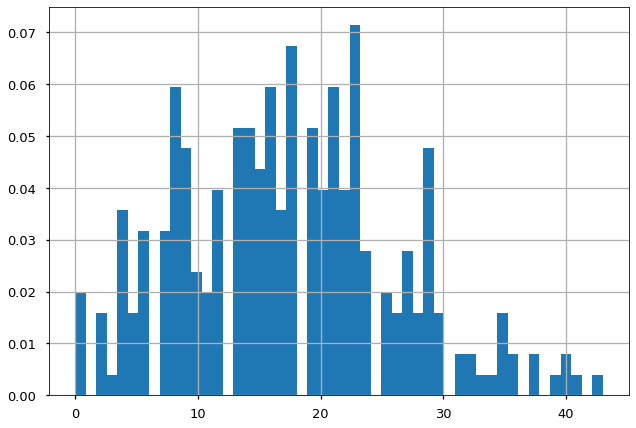

In [84]:
hist = df.hist(density = True, bins = 50)  # zameniti sa normed = True u staroj verziji
plt.show()

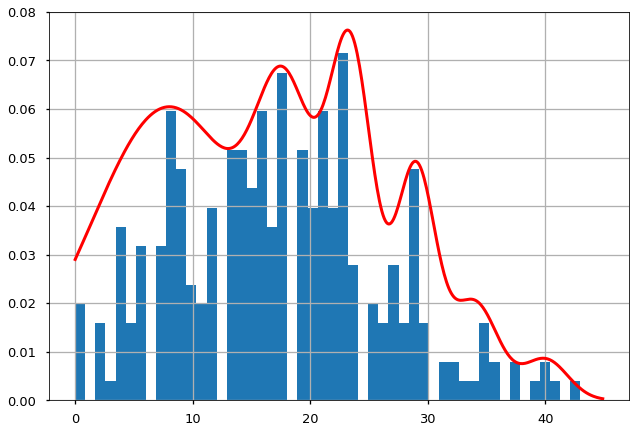

In [85]:
# Aproksimacija Gausovom raspodelom
hist = df.hist(density = True, bins = 50)
korak = 0.1
x = np.arange(0, 45, korak)

m1 = 8
sig1 = 6.6

m2 = 18
sig2 = 2.5

m3 = 23.5
sig3 = 1.9

m4 = 29
sig4 = 1.7

m5 = 34
sig5 = 2

m6 = 40
sig6 = 1.9 

P_norm_mix = np.array(norm.pdf(x, m1, sig1) +  0.3 * norm.pdf(x, m2, sig2) + 0.32 * norm.pdf(x, m3, sig3) +
                     0.2 * norm.pdf(x, m4, sig4) + 0.1 * norm.pdf(x, m5, sig5) + 0.04 * norm.pdf(x, m6, sig6))

plt.plot(x, P_norm_mix, 'r', linewidth = 3.0)

In [86]:
# Verovatnoca se racuna pribliznom integracijom odredjene gustine raspodele

# Odredjujemo povrsine malih pravougaonika sirine 'korak' i visine odredjene funkcijom raspodele
# Odredicemo verovatnocu da je igrac postigao izmedju 13 i 21 poena
PP = np.array([korak * z for x, z in zip(x, P_norm_mix) if (x >= 13  and x <= 21)])

# sumiramo povrsine svih malih pravougaonika
P_trazeno = PP.sum(axis = 0)
print(P_trazeno)

0.49429970139245605


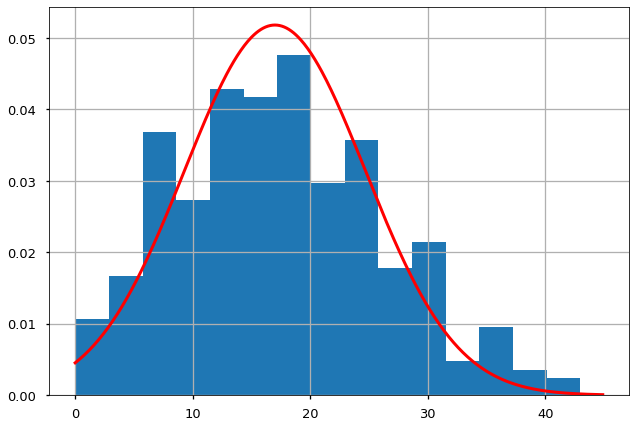

In [148]:
# Aproksimacija Gausovom raspodelom - II nacin
hist = df.hist(density = True, bins = 15)
korak = 0.1
x = np.arange(0, 45, korak)

m = 17
sig = 7.7

# norm.pdf (biblioteka stats) 
P_norm_mix = norm.pdf(x, m, sig)

plt.plot(x, P_norm_mix, 'r', linewidth = 3.0)

In [153]:
# Verovatnoca se racuna pribliznom integracijom odredjene gustine raspodele
br_poena_1 = 10
br_poena_2 = 20
PP = np.array([korak * z for x, z in zip(x, P_norm_mix) if (x >= br_poena_1  and x <= br_poena_2)])

P_trazeno = PP.sum(axis = 0)
print(P_trazeno)

0.47404606852183473


## Test Kolmogorova i Smirnova

In [154]:
# Testiracemo da li je ovo normalna raspodela

velicina_uzorka = 100

# u args stavljamo ocene matematickog ocekivanja i standardne devijacije
kstest(df.sample(velicina_uzorka).dropna().values.T, cdf = "norm", args = (df.dropna().values.mean(), df.dropna().values.std()))

KstestResult(statistic=0.07291029698148849, pvalue=0.6586559485008149)

p vrednost je velika (> 0.05) sto implicira slab dokaz protiv nulte hipoteze (da je raspodela normalna), tako da je ne odbacujemo

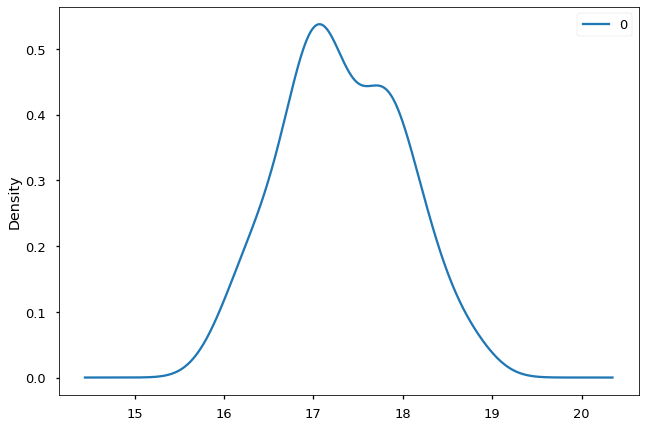

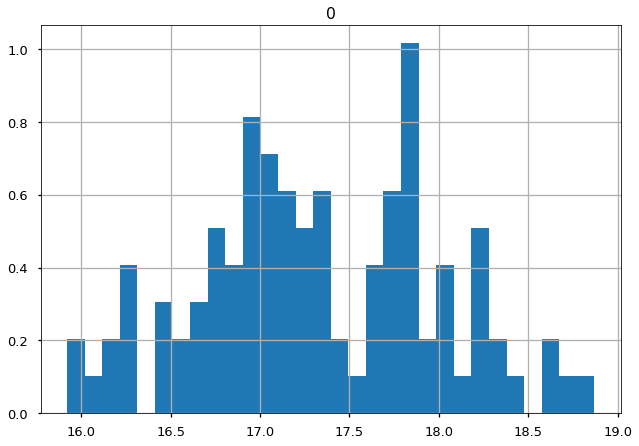

In [165]:
# Testiramo estimatore srednje vrednosti
estimatori_srednje_vrednosti = []

velicina_uzorka = 100

# broj estimacija, svaka je bazirana na uzorku velicine 'velicina_uzorka'
broj_estimacija_srednjih_vrednosti = 100
for x in range(broj_estimacija_srednjih_vrednosti):
    
    uzorak = df.sample(velicina_uzorka)
    estimatori_srednje_vrednosti.append(uzorak.dropna().values.mean())
    
# plotujemo estimaciju gustine verovatnoce raspodele srednjih vrednosti pomocu histograma
pd.DataFrame(estimatori_srednje_vrednosti).plot(kind = "density")

# histogram srednjih vrednosti
hist = pd.DataFrame(estimatori_srednje_vrednosti).hist(normed = True, bins = 30)
plt.show()

Vidimo da je raspodela priblizno normalna

In [166]:
# Testiramo da li estimatori imaju normalnu raspodelu
kstest(estimatori_srednje_vrednosti, cdf = "norm", args = (df.dropna().values.mean(), 
                                                           df.dropna().std() / velicina_uzorka ** 0.5))

KstestResult(statistic=0.09459330793792398, pvalue=0.31374486578239674)

p vrednost je dovoljno velika da bismo mogli da tvrdimo da raspodela tezi normalnoj raspodeli, sto sledi
iz Centralne granicne teoreme

## Hi-kvadrat test

In [168]:
hist = np.histogram(estimatori_srednje_vrednosti)

In [178]:
# Testiranje hipoteze hi-kvadrat testom za raspodelu estimatora
chisquare(hist[0])

Power_divergenceResult(statistic=32.2, pvalue=0.0001838810225873404)

In [180]:
hist

(array([ 5,  7, 10, 19, 17,  7, 18, 10,  3,  4], dtype=int64),
 array([15.92 , 16.215, 16.51 , 16.805, 17.1  , 17.395, 17.69 , 17.985,
        18.28 , 18.575, 18.87 ]))

## 5) Estimacija intervala poverenja ocena odredjenih parametara

In [181]:
data_por.head()

,PTS,FG%
0,29,42.3
1,29,66.7
2,25,55.6
3,21,53.3
4,33,52.0


In [182]:
len(data_por)

293

In [183]:
# Posto je dovoljno veliki uzorak podataka kozemo koristiti kvantile iz N(0,1) raspodele

In [188]:
# Interval poverenja 99% za matematicko ocekivanje broja poena
alpha = 0.01

n = len(data_por)

# Stampamo estimiranu vrednost
print(data_por.mean()["PTS"])

# Svodjenje na Z-raspodelu (N(0,1))
red_kvantila = 1 - alpha / 2

# Određujemo kvantil zadatog reda
Kvantil = norm.ppf(red_kvantila)

margina = Kvantil * (data_por.std()["PTS"] / n ** 0.5)

interval_poverenja_MO = (data_por.mean()["PTS"] - margina, data_por.mean()["PTS"] + margina)
interval_poverenja_MO

17.38225255972696


(16.066454010337754, 18.698051109116168)

In [192]:
# Interval poverenja 95% za varijansu - procenat suta
alpha = 0.05

# Stampamo estimiranu vrednost
print(data_por.var()["FG%"])

# Kvantili odgovarajucih redova hi kvadrat raspodele sa n-1 stepeni slobode
Kvantil1 = chi2.ppf(1 - alpha / 2, df = n - 1)
Kvantil2 = chi2.ppf(alpha / 2, df = n - 1)

interval_poverenja_Var = ((n - 1) * data_por.var()["FG%"] / Kvantil1, ((n - 1) * data_por.var()["FG%"]) / Kvantil2)
interval_poverenja_Var

304.8707955023613


(260.88671089459683, 361.06144683039594)

## 6) Regresija (Linearna, Visestruka i Nelinearna)

# Linearna regresija

In [218]:
import statsmodels.formula.api as sm

# Trazimo linearnu funkciju zavisnosti izmedju promenljivih PTS i FG%
data_por.columns = ["PTS", "FG"]
data_por.head()

,PTS,FG
0,29,42.3
1,29,66.7
2,25,55.6
3,21,53.3
4,33,52.0


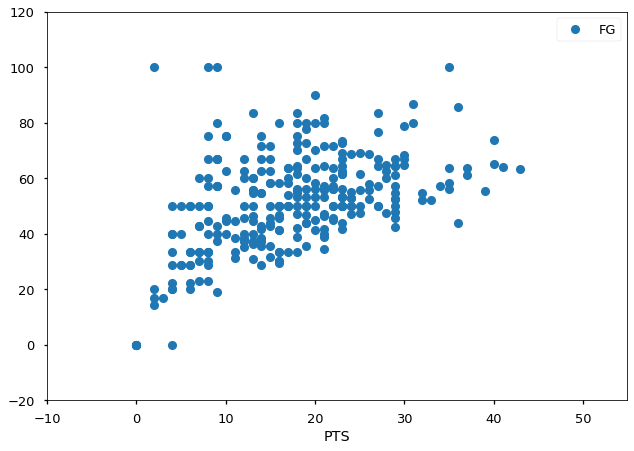

In [219]:
data_por.plot("PTS", "FG", style = "o")

plt.xlim([-10, 55])
plt.ylim([-20, 120])
plt.show()

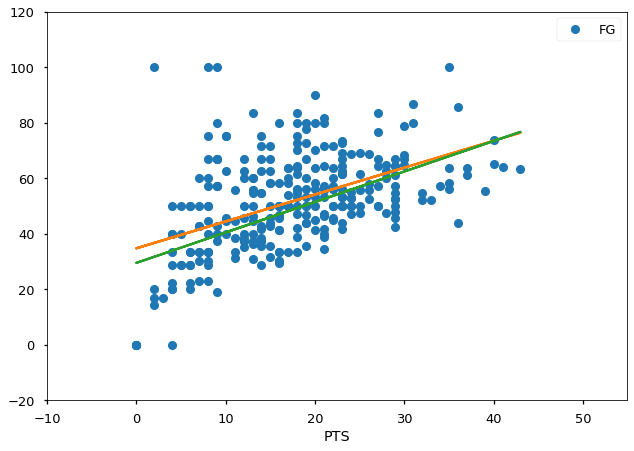

In [238]:
# fit() funkcijom odredjujemo parametre k i n za nasu linearnu funkciju f(x) = k * x + n
# uz pomoc analiziranja vektora FG i PTS
Rez1 = sm.ols('FG ~ PTS', data_por).fit()
Rez2 = sm.ols('FG ~ PTS', data_por[:-100]).fit()  # bez poslednjih 50 tacaka

data_por.plot("PTS", "FG", style = "o")
plt.plot(data_por.PTS, Rez1.fittedvalues)
plt.plot(data_por.PTS[:-100], Rez2.fittedvalues)

plt.xlim([-10, 55])
plt.ylim([-20, 120])
plt.show()

In [230]:
# Rezime regresije
print(Rez1.summary())
print(Rez2.summary())

                            OLS Regression Results                            
Dep. Variable:                     FG   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     89.36
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           1.14e-18
Time:                        00:41:15   Log-Likelihood:                -1214.0
No. Observations:                 293   AIC:                             2432.
Df Residuals:                     291   BIC:                             2439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.7265      1.992     17.437      0.0

#### Interpretacija rezulata:

#### Df Residuals - broj podataka (Observations) minus broj parametara koje estimiramo
#### Df Model - broj nezavisnih prmenljivih (u ovom slucaju samo jedna: x)
#### R squared - kvadrat indeksa krivolinijske korelacije
#### Adj. R-squared: modifikovan R^2, tako da se bolje uzima u obzir broj parametara (kaznjava koriscenje velikog broja parametara!)
#### F-statistic - vrednost statistike koja se koristi za testiranje hipoteze (H0) da je y nezavisno (u zdruzenom smislu) od svih nezavisnih promenljivih (velika vrednost je u korist odbacivanja hipoteze H0)
####  Prob (F-statistic) - p-vrednost testa, mala vrednost znaci da cemo odbaciti hipotezu o nezavisnosti sa malim nivoom znacajnosti: $\alpha \geq p$
####  Log-Likelihood - Logaritam verodostojnosti dobijenih parametara
#### AIC, BIC - Mere koje govore o kvalitetu modela - manja vrednost znaci bolji model! (bolje kaznjavaju kompleksne modele od R vrednosti)
#### std err - standardna greska (estimacija standardne devijacije) ocena parametara
#### t - vrednost t statistike za testiranje hipoteze (H0) da je y nezavisno od odgovarajuceg x
#### P>|t|  - p -vrednost testa (mala vrednost znaci da odbacujemo hipotezu H0 sa velikom sigurnoscu - malim nivoom znacajnosti)
#### [0.025      0.975] - 95% interval poverenja za parametre
#### Omnibus - test normalnosti reziduala (H0 je hipoteza da jeste normalna raspodela suma!)
#### Prob(Omnibus) - p-vrednost testa normalnosti (jako mala vrednost znaci da odbacujemo hipotezu da je sum normalan!)
####  Skew - ocena nesimetricnosti raspodele reziduala (za normalnu raspodelu (simetricna je)) treba da bude 0
#### Kurtosis - mera "tezine" repova gustine respodele (normalna PDF ima vrednost 3), npr. t-raspodela ima "lakse" repove i time  vecu ovu vrednost
#### Durbin-Watson - mera autokorelacije kod reziduala (prema modelu bi trebalo da su nezavisni, vrednost oko 2 ukazuje na nekorelisanost tj. nezavisnost reziduala)
#### Jarque-Bera (JB) - jos jedan test normalnosti
#### Prob(JB) - p vrednost, jako mala vrednost znaci da odbacujemo hipotezu o normalnosti sa malim nivoom znacajnosti
#### Cond. No. - mera korelisanosti ulaznih promenljivih

## Koristeci popularnu bibloteku za masinsko ucenje - sklearn

0.3439575026909891
0.2349414497404367


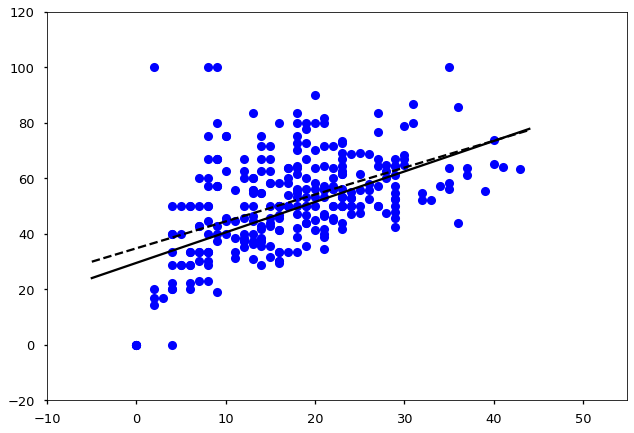

In [255]:
from sklearn.linear_model import LinearRegression

# kreiramo matricu za date podatke
dataM = np.matrix(data_por)

# kreiramo regresione objekte i fitujemo podatke
cln = LinearRegression()  # izbaceno 100 tacaka
org = LinearRegression()  # originalni skup

X, Y = dataM[:, 0], dataM[:, 1]
cln.fit(X[:-100], Y[:-100])  # fitujemo model bez 100 tacaka
org.fit(X, Y)  # sa svim podacima

# prikaz R ^ 2 indeksa
print(cln.score(X[:-100], Y[:-100]))
print(org.score(X, Y))

# plotujemo podatke
plt.plot(data_por.PTS, data_por.FG, 'bo')
plt.xlim([-10, 55])
plt.ylim([-20, 120])

# ono cemu najcesce sluzi obuceni model je da se posle vrsi predikcija za Y
# u novim tackama X 

# Generisemo nove tacke
test = np.c_[np.arange(-5, 45, 1)] # mora da bude vektor kolona

plt.plot(test, cln.predict(test), 'k')
plt.plot(test, org.predict(test), 'k--')
plt.show()

## Visestruka regresija

In [267]:
from statsmodels.formula.api import ols

df = data.loc[:, ["PTS", "FG%", "MIN"]]
df["FG%"] = df["FG%"].str.rstrip('%').astype('float')
df.columns = ["PTS", "FG", "MIN"]
df.head()

,PTS,FG,MIN
0,29,42.3,41
1,29,66.7,36
2,25,55.6,34
3,21,53.3,38
4,33,52.0,64


In [268]:
# model nezavisan od procenta suta
model1 = ols("PTS ~ MIN", df).fit() 
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     211.1
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           2.46e-36
Time:                        01:22:07   Log-Likelihood:                -970.67
No. Observations:                 293   AIC:                             1945.
Df Residuals:                     291   BIC:                             1953.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.0982      1.596     -3.195      0.0

In [271]:
# model zavisan od dva faktora - minutaze i procenta suta
model2 = ols("PTS ~ FG + MIN", df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     212.2
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           1.67e-57
Time:                        01:23:36   Log-Likelihood:                -918.49
No. Observations:                 293   AIC:                             1843.
Df Residuals:                     290   BIC:                             1854.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.3425      1.574     -9.111      0.0

In [273]:
# model zavisan od dva faktora (minutaze i procenta suta) i njihove interakcije (proizvoda)
model3 = ols("PTS ~ MIN * FG", df).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     180.2
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           7.43e-66
Time:                        01:25:06   Log-Likelihood:                -896.11
No. Observations:                 293   AIC:                             1800.
Df Residuals:                     289   BIC:                             1815.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3325      2.822      0.827      0.4

## Kubna regresija

In [279]:
A = np.array(data_por["PTS"])

A = np.array([np.ones(len(A)), A, A ** 2, A ** 3])
y = np.array(data_por["FG"])

# nalazenje optimalnih parametara
w3 = np.linalg.lstsq(A.T, y)[0]
print("w3 = ", w3)

w3 =  [ 1.42231527e+01  4.94288753e+00 -1.92907364e-01  2.58455005e-03]


C:\Users\Sovta\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


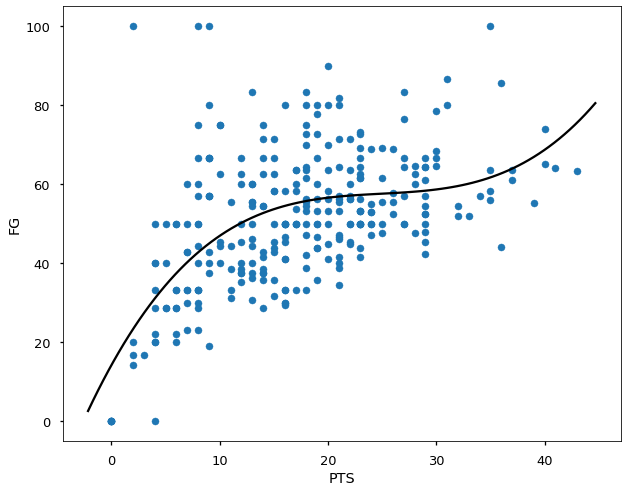

In [287]:
# funkcija koja racuna fitovanu verdnost u tacki x, za date parametre w
def f(x, w):
    return w[0] + w[1] * x + w[2] * x ** 2 + w[3] * x ** 3

ax = data_por.plot(kind = 'scatter', s = 50, x = "PTS", y = "FG", figsize=[10, 8])
x0, x1 = plt.xlim()
opseg = x1 - x0
X = np.arange(x0, x1, opseg / 100.0)

ax.plot(X, f(X, w3), 'k')
plt.show()